## Data visualization

In this first notebook, basic information will be loaded, processed and showed.

The necessary functions are loaded in this first cell. A function for visualization is created taking the base image and masks and returning full visualization: masks over base image.

In [12]:
import numpy as np
import ia870 as MM
import ia636 as ia
import homewill as FW
import nibabel as ni
import scipy.interpolate as spline
import scipy.misc as misc
import matplotlib.pyplot as plt
from glob import glob
from matplotlib import rcParams
import scipy.spatial.distance as distance
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
%matplotlib inline

def plot_mask(im,mask,mask2,escala,mask_name):
    con_mask = np.logical_xor(mask,MM.iaero(mask))
    con_mask = np.ma.masked_where(con_mask == 0,con_mask)
    con_mask2 = np.logical_xor(mask2,MM.iaero(mask2))
    con_mask2 = np.ma.masked_where(con_mask2==0,con_mask2)
        
    plt.figure()
    plt.axis('off')
    plt.imshow(im,cmap='gray')
    plt.imshow(con_mask,cmap=mpl.cm.jet_r,interpolation='none')
    plt.imshow(con_mask2,cmap=mpl.cm.brg_r,interpolation='none')
    plt.show()

Path is defined (where images are saved). For each subject, T1 image is loaded and manual mask is reconstructed. Brain mask is loaded. In all of these images, mid-sagittal slice is selected. Each segmentation is loaded and corpus callosum shape signature is calculated. Finally, images are drawn.

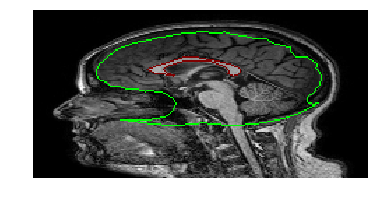

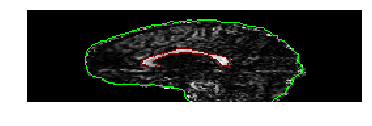

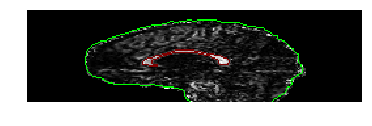

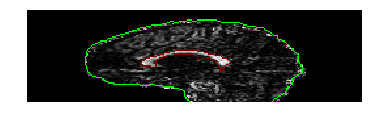

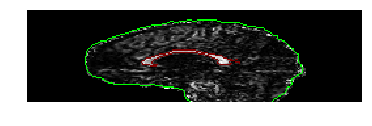

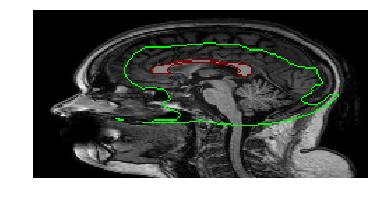

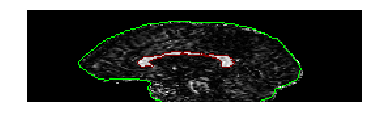

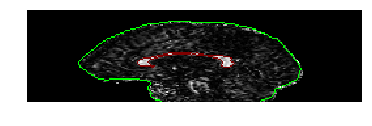

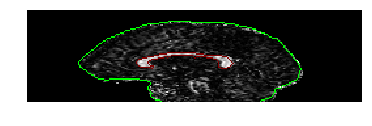

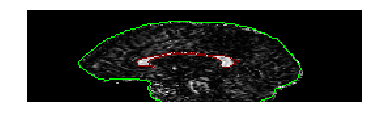

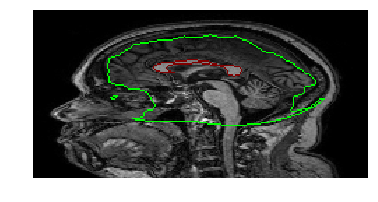

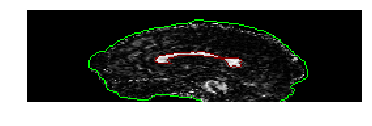

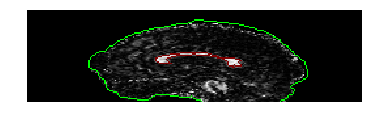

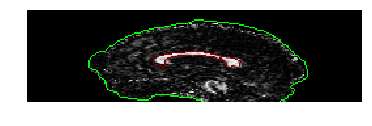

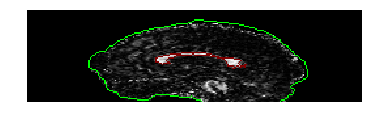

In [11]:
paths = glob('my_dataset/*')

s = 700 #Smoothness
raios = [0.35,0.08] #Adjusting radius
res = 500 #Número de pontos de construção da spline
cum_metrics = np.array([]).reshape(2,0,4)

for path in paths:
    ################# Initializing profiles #################
    padrao_0 = np.array([]).reshape(0,res)
    seg_0 = np.array([]).reshape(0,res)
    seg_1 = np.array([]).reshape(0,res)
    seg_2 = np.array([]).reshape(0,res)
    seg_3 = np.array([]).reshape(0,res)
    
    ################# Loading data #################
    t1 = ni.load('{}/anat/t1.nii.gz'.format(path)).get_data()
    tagfilename = glob('{}/anat/*.tag'.format(path))[0]
    tag = np.loadtxt(tagfilename, skiprows=4, comments=';')
    seg_mask_t1 = FW.crmksor(t1.shape, tag).astype(bool)
    slcnz = np.nonzero(np.sum(np.sum(seg_mask_t1, axis=0), axis=0))
    fat_md_t1 = slcnz[0][len(slcnz[0])/2]
    mask_t1_ms = seg_mask_t1[:,:,fat_md_t1]

    cc_dil = MM.iadil(mask_t1_ms,MM.iasedisk(70))
    t1_md = t1[:,:,fat_md_t1]

    mask_out_t1 = ni.load('{}/anat/nodif_brain_t1_mask.nii.gz'.format(path)).get_data().astype(bool)
    mask_out_t1_md = mask_out_t1[:,:,fat_md_t1]
    mask_ajs_t1 = np.logical_and(mask_out_t1_md,cc_dil).T
    mask_ajs_t1 = mask_ajs_t1[::-2]
    
    #### Diffusion images
    DTI_fissure = np.load('{}/segm/DTI_fissure.npy'.format(path))
    wFA_ss = np.load('{}/segm/wFA_ss.npy'.format(path))
    mask_out = ni.load('{}/dwi/nodif_brain_mask.nii.gz'.format(path)).get_data().astype(bool)
    mask_out = mask_out.transpose(0,2,1)
    mask_out = mask_out[DTI_fissure,::-1,::-1]
    escala_res = [3*wFA_ss.shape[-2],2*wFA_ss.shape[-1]]
    
    ################# Standards #################
    #### Standard 0 - Manual on T1
    mask_p0 = np.rot90(mask_t1_ms, k=1)[::2]
    pp0 = FW.get_spline(mask_p0,s)
    for raio in raios:
        padrao_0 = np.vstack((padrao_0, FW.get_profile(pp0, n_samples=res, radius=raio)))

    ################# Segmentations #################
    #### Segmentation 0 - Watershed
    mask_s0 = np.load(str(path)+'/segm/mask_Watershed.npy')
    ps0 = FW.get_spline(mask_s0,s)
    for raio in raios:
        seg_0 = np.vstack((seg_0, FW.get_profile(ps0, n_samples=res, radius=raio)))

    #### Segmentation 1 - ROQS
    mask_s1 = np.load(str(path)+'/segm/mask_ROQS.npy')
    ps1 = FW.get_spline(mask_s1,s)
    for raio in raios:
        seg_1 = np.vstack((seg_1, FW.get_profile(ps1, n_samples=res, radius=raio)))

    #### Segmentation 2 - Pixel-based
    mask_s2 = np.load(str(path)+'/segm/mask_pixel-bs.npy')
    ps2 = FW.get_spline(mask_s2,s)
    for raio in raios:
        seg_2 = np.vstack((seg_2, FW.get_profile(ps2, n_samples=res, radius=raio)))
        
    #### Segmentation 3 - GNG
    mask_s3 = np.load(str(path)+'/segm/mask_GNG.npy')
    ps3 = FW.get_spline(mask_s3,s)
    for raio in raios:
        seg_3 = np.vstack((seg_3, FW.get_profile(ps3, n_samples=res, radius=raio)))
    mask_s3 = mask_s3[::3,::2]
        
    ################# Showing figures #################
    t1_ms = np.rot90(t1[:,:,fat_md_t1], k=1)[::2]
    escala_t1 = [2*t1_ms.shape[-2],2*t1_ms.shape[-1]]
    plot_mask(t1_ms,mask_p0,mask_ajs_t1,escala_t1,"manual (padrão-ouro)")
    plot_mask(wFA_ss,mask_s0,mask_out,escala_res,"Watershed")
    plot_mask(wFA_ss,mask_s1,mask_out,escala_res,"ROQS")
    plot_mask(wFA_ss,mask_s2,mask_out,escala_res,"Pixel_based")
    plot_mask(wFA_ss,mask_s3,mask_out,escala_res,"GNG")